In [1]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import * 
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator


In [2]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/single_cell_stim/scnn1a/09-18-25/"
export_summary = data_dir + "export_summary_barrel.csv"
barrel_df = pd.read_csv(export_summary)
barrel_df

,ROI,amp,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording,trace,amp_array,Stim_Target,Stim_Current
0,1,0.378864,49.484342,45.484342,1_1_rois,9/18/2025,1,1,1,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,SC,40
1,1,0.496017,49.484342,45.484342,1_1_rois,9/18/2025,1,1,2,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,SC,60
2,1,0.171472,49.484342,45.484342,1_1_rois,9/18/2025,1,1,3,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,SC,20
3,1,0.213586,49.484342,45.484342,1_1_rois,9/18/2025,1,1,4,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,SC,30
4,1,0.503666,49.484342,45.484342,1_1_rois,9/18/2025,1,1,5,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,SC,40
5,1,0.365513,49.484342,45.484342,1_1_rois,9/18/2025,1,1,6,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,SC,35
6,1,0.350280,57.202301,44.508150,1_2_rois,9/18/2025,1,2,1,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,random,35
7,1,0.679626,57.202301,44.508150,1_2_rois,9/18/2025,1,2,2,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,random,60
8,1,0.575172,57.202301,44.508150,1_2_rois,9/18/2025,1,2,3,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,random,40
9,1,0.315601,57.202301,44.508150,1_2_rois,9/18/2025,1,2,4,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,C:/Users/jjudge3/Desktop/Data/single_cell_stim...,random,30


In [ ]:
def read_traces_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)
    return data_arr

def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))


Processing Date: 9/18/2025, Slice: 1, Location: 1, Stim_Target: SC
Processing Date: 9/18/2025, Slice: 1, Location: 2, Stim_Target: SC


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Processing Date: 9/18/2025, Slice: 1, Location: 3, Stim_Target: random
Processing Date: 9/18/2025, Slice: 1, Location: 4, Stim_Target: random
Processing Date: 9/18/2025, Slice: 2, Location: 1, Stim_Target: SC
Processing Date: 9/18/2025, Slice: 2, Location: 2, Stim_Target: random


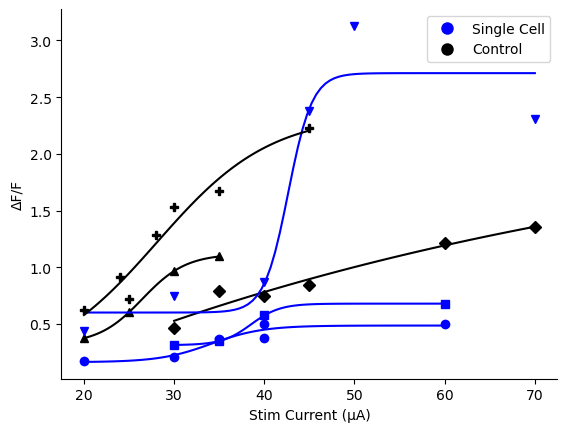

T-test between SC and Control steepness coefficients: t=2.300, p=0.083


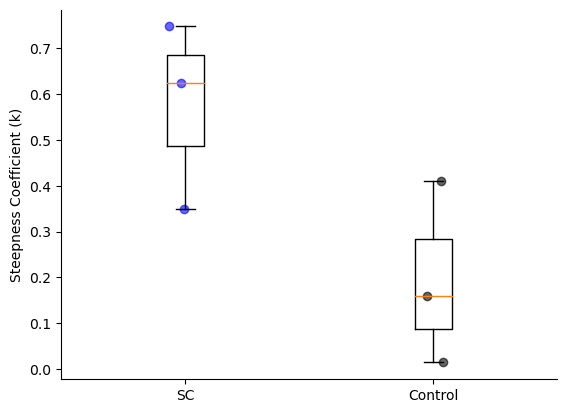

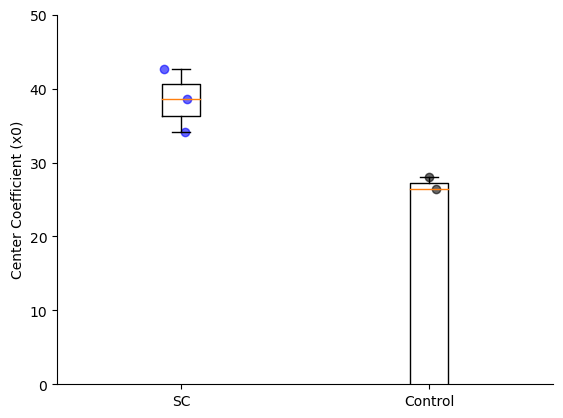

Steepness Coefficients (k):
SC: [0.35011676979724365, 0.6235915816809254, 0.7478446705217405]
Control: [0.4104673960401783, 0.014399670566830702, 0.1589913370957688]

Center Coefficients (x0):
SC: [34.088906094277824, 38.52928645364772, 42.64886876776105]
Control: [26.475400931725318, -359.33854904734864, 28.09805856068709]


In [24]:
# For each date/slice/loc, make a curve of amplitude versus Stim_Current
# fit a logistic curve to the data of each date/slice/loc
colors = ['b', 'k', 'g', 'r', 'c', 'm', 'y']
markers = ['o', 's', '^', 'D', 'v', 'P', '*']
steepness_coefficients = {'SC': [], 'random': []}
center_coefficients = {'SC': [], 'random': []}
plt.figure()
i_color = -1
i_marker = -1
for date in barrel_df['Date'].unique():
    date_df = barrel_df[barrel_df['Date'] == date]
    for slice in date_df['Slice'].unique():
        slice_df = date_df[date_df['Slice'] == slice]

        for loc in slice_df['Location'].unique():

            # read in value of Stim_Target
            stim_target = loc_df['Stim_Target'].values[0]
            print(f'Processing Date: {date}, Slice: {slice}, Location: {loc}, Stim_Target: {stim_target}')
            i_marker += 1
            i_color = 0 if stim_target == "SC" else 1
            loc_df = slice_df[slice_df['Location'] == loc]
            
            plt.plot(loc_df['Stim_Current'], loc_df['amp'], marker=markers[i_marker], linestyle='None', 
                     label="Single Cell" if stim_target == "SC" else "Control", color=colors[i_color % len(colors)])
            # Fit a logistic curve
            def logistic(x, L ,x0, k, b):
                return L / (1 + np.exp(-k*(x-x0))) + b
            fit_success = False
            try:
                p0 = [max(loc_df['amp']), np.median(loc_df['Stim_Current']),1,min(loc_df['amp'])] # initial guesses
                popt, _ = curve_fit(logistic, loc_df['Stim_Current'], loc_df['amp'], maxfev=10000, p0=p0)
                x_fit = np.linspace(min(loc_df['Stim_Current']), max(loc_df['Stim_Current']), 100)
                y_fit = logistic(x_fit, *popt)
                fit_success = True
            except:
                print(f'Could not fit logistic curve for Date: {date}, Slice: {slice}, Location: {loc}, Stim_Target: {stim_target}')

            if fit_success:
                plt.plot(x_fit, y_fit, label=f'Fit {date} {slice}-{loc}', color=colors[i_color % len(colors)])
                steepness_coefficients[stim_target].append(popt[2]) # k is the steepness
                center_coefficients[stim_target].append(popt[1]) # x0 is the center
plt.xlabel('Stim Current (µA)')
plt.ylabel('ΔF/F')
# legend: SC (blue) versus random (black)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='Single Cell', markerfacecolor='b', markersize=10),
                        plt.Line2D([0], [0], marker='o', color='w', label='Control', markerfacecolor='k', markersize=10)])
# spines off
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# boxplot of steepness coefficients: SC versus Control
plt.figure()
plt.boxplot([steepness_coefficients['SC'], steepness_coefficients['random']], labels=['SC', 'Control'])
x_jitter = np.random.normal(1, 0.04, size=len(steepness_coefficients['SC']))
plt.scatter(x_jitter, steepness_coefficients['SC'], color='b', alpha=0.6)
x_jitter = np.random.normal(2, 0.04, size=len(steepness_coefficients['random']))
plt.scatter(x_jitter, steepness_coefficients['random'], color='k', alpha=0.6)
# t-test
t_stat, p_val = ttest_ind(steepness_coefficients['SC'], steepness_coefficients['random'], equal_var=False)
print(f'T-test between SC and Control steepness coefficients: t={t_stat:.3f}, p={p_val:.3f}')
plt.xlim(0.5, 2.5)
plt.ylabel('Steepness Coefficient (k)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# boxplot of center coefficients: SC versus Control
plt.figure()
plt.boxplot([center_coefficients['SC'], center_coefficients['random']], labels=['SC', 'Control'])
x_jitter = np.random.normal(1, 0.04, size=len(center_coefficients['SC']))
plt.scatter(x_jitter, center_coefficients['SC'], color='b', alpha=0.6)
x_jitter = np.random.normal(2, 0.04, size=len(center_coefficients['random']))
plt.scatter(x_jitter, center_coefficients['random'], color='k', alpha=0.6)

plt.xlim(0.5, 2.5)
plt.ylabel('Center Coefficient (x0)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, 50)
plt.show()

print("Steepness Coefficients (k):")
print("SC:", steepness_coefficients['SC'])
print("Control:", steepness_coefficients['random'])

print("\nCenter Coefficients (x0):")
print("SC:", center_coefficients['SC'])
print("Control:", center_coefficients['random'])

In [4]:
# make a new dataframe with normalized amp and current
df_export_norm = df_export.copy()

# restrict to Drug == ACSF only
df_export_norm = df_export_norm[df_export_norm['Drug'] == 'ACSF']

# min-max normalize the amp, each Date/Slice is normalized independently
df_export_norm['amp'] = (df_export_norm['amp'] - 
                         df_export_norm.groupby(['Date', 'Slice', 'ROI'])['amp'].transform('min')) / \
                        (df_export_norm.groupby(['Date', 'Slice', 'ROI'])['amp'].transform('max') - 
                        df_export_norm.groupby(['Date', 'Slice', 'ROI'])['amp'].transform('min'))   

# center the current on the Activation_Threshold (via subtraction only)
#df_export_norm['Stim_Current'] = df_export_norm['Stim_Current'] - df_export_norm['Activation_Threshold']

# add more data to the plot from ec_summary_df
#ec_summary_df['amp'] = (ec_summary_df['amp'] - 
#                         ec_summary_df.groupby(['Date', 'Slice'])['amp'].transform('min')) / \
#                        (ec_summary_df.groupby(['Date', 'Slice'])['amp'].transform('max') - 
#                        ec_summary_df.groupby(['Date', 'Slice'])['amp'].transform('min'))
ec_summary_df

,ROI,amp,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording,Stim_Current
0,1,0.432120,46.963964,41.873874,1_rois,11/11/2024,1,1,1,10
1,2,0.298402,61.449102,57.742515,1_rois,11/11/2024,1,1,1,10
2,3,0.192079,28.993289,28.697987,1_rois,11/11/2024,1,1,1,10
3,1,1.003620,46.963964,41.873874,1_rois,11/11/2024,1,1,2,50
4,2,0.200140,61.449102,57.742515,1_rois,11/11/2024,1,1,2,50
5,3,0.204946,28.993289,28.697987,1_rois,11/11/2024,1,1,2,50
6,1,1.110950,46.963964,41.873874,1_rois,11/11/2024,1,1,3,80
7,2,0.502393,61.449102,57.742515,1_rois,11/11/2024,1,1,3,80
8,3,0.271971,28.993289,28.697987,1_rois,11/11/2024,1,1,3,80
9,1,0.717715,46.963964,41.873874,1_rois,11/11/2024,1,1,4,30


Plotting ROI: 1 i= 1 key= ('11/11/2024', 1)
Plotting ROI: 2 i= 3 key= ('11/11/2024', 1)
Plotting ROI: 3 i= 4 key= ('11/11/2024', 1)


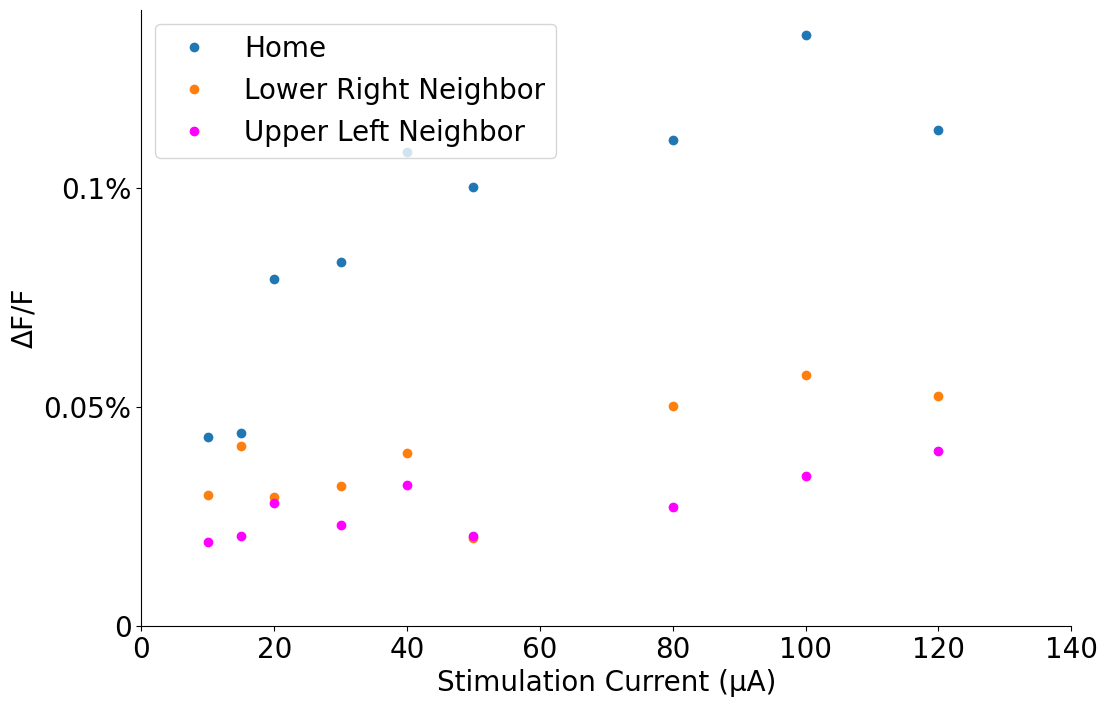

In [8]:
# make plots of amp vs. Stim_Current, with  different shape for each Date/Slice 
# and different color for each Date/Slice

# set matplotlib font size
plt.rcParams.update({'font.size': 20})


fig, ax = plt.subplots(figsize=(12, 8))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
i = 0

df_export_norm_single = df_export_norm[df_export_norm['Electrode_Type'] == 'single']
df_export_norm_ec1 = df_export_norm[df_export_norm['Electrode_Type'] == 'extracellular']
#df_export_norm_ec1['Stim_Current'] = df_export_norm_ec1['Stim_Current'] + df_export_norm_ec1['Activation_Threshold']

"""for key, grp in df_export_norm_single.groupby(['Date', 'Slice']):
    i = (i + 1) % len(colors)
    if i != 2:
        i += 1
        continue

    #ax = grp.plot(ax=ax, kind='scatter', x='Stim_Current', y='amp', marker='o', color=colors[i])

    # fit a logisitic curve to this group's data and plot it
    x = grp['Stim_Current']
    y = grp['amp']
    '''p0 = {'c': [0.9, 3, 0.05, 0, 0.1],
          'r': [0.9, 3, 0.05, 0, 0.1],
          'b': [0.9, 1, 0.05, 0, 0.1],
          'm': [0.9, 1, 0.05, 0, 0],
          'g': [0.9, 1, 0.05, 10, 0.1] }[colors[i]]
    try:
        popt, pcov = curve_fit(logistic_fn, x, y, p0=p0)
    except:
        print("Failed to fit logistic curve for group", key, "color" , colors[i])
        i += 1
        continue
    x_fit = np.linspace(-30, 30, 100)
    y_fit = logistic_fn(x_fit, *popt)
    ax.plot(x_fit, y_fit, color=colors[i], alpha=0.3, linewidth=3)'''

    # bin this group and plot the mean
    grp.groupby('Stim_Current')['amp'].mean().plot(ax=ax,
                        marker='o', color=colors[i], label='Single Cell Stimulation')

    
    i += 1
"""


# make a second plot of extracellular data, df/f vs. Stim_Current, binned by Stim_Current
# Now bin to the actual Stim_Current values, not the centered values
colors = ['tab:blue', 'black', 'tab:orange', 'magenta', 'tab:purple', 'tab:brown', 'tab:pink']
labels = ['Home', '', 'Lower Right Neighbor', 'Upper Left Neighbor', '', '']
i = 0
for roi in ec_summary_df['ROI'].unique():
    ec_subset = ec_summary_df[ec_summary_df['ROI'] == roi]
    for key, grp in ec_subset.groupby(['Date', 'Slice']):
        color = colors[i]
        i+=1
        if i == 2:
            continue
        
        #ax = grp.plot(ax=ax, kind='scatter', x='Stim_Current', y='amp', marker='o')
        # bin this group and plot the mean and SEM
        #grp['Stim_Current_bin'] = pd.cut(grp['Stim_Current'], bins=10, labels=False)
        #grp['Stim_Current_bin'] = ((grp['Stim_Current_bin']) * grp['Stim_Current'].max() / 10) + grp['Stim_Current'].min()
        # don't connect dots, just plot the mean
        #grp.groupby('Stim_Current')['amp'].mean().plot(ax=ax, yerr=grp.groupby('Stim_Current')['amp'].sem(),
        #                        marker='o', color=color, label=roi + ' ' + str(key))
        grp.groupby('Stim_Current')['amp'].mean().plot(ax=ax,
                            marker='o', color=color, label=labels[i-1], style="o")
        print("Plotting ROI:", roi, 'i=', i, 'key=', key)


'''# put the slices from the ec_summary_df_2 and ec_summary_df_3 slice 1's on the plot
ec_summary_df_2 = ec_summary_df_2[(ec_summary_df_2['Slice'] == 1) & (ec_summary_df_2['Location'] == 2) & (ec_summary_df_2['Recording'] <= 3)]
ec_summary_df_2['amp'] = (ec_summary_df_2['amp'] -
                            ec_summary_df_2.groupby(['Date', 'Slice'])['amp'].transform('min')) / \
                            (ec_summary_df_2.groupby(['Date', 'Slice'])['amp'].transform('max') -
                            ec_summary_df_2.groupby(['Date', 'Slice'])['amp'].transform('min'))


# plot the data
ec_summary_df_2.groupby('Stim_Current')['amp'].mean().plot(ax=ax, yerr=ec_summary_df_2.groupby('Stim_Current')['amp'].sem(),
                        marker='o', color=colors[i+1], label='Slice ' + str(i+1))
#ec_summary_df_3.groupby('Stim_Current')['amp'].mean().plot(ax=ax, yerr=ec_summary_df_3.groupby('Stim_Current')['amp'].sem(),
#                        marker='o', color=colors[i+2], label='Slice ' + str(i+2))'''


# spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '0.05%', '0.1%'])
ax.legend()
ax.set_xlabel('Stimulation Current (μA)')
ax.set_ylabel('ΔF/F')
#ax.set_xticks([-55, -30, -5, 20, 45])
#ax.set_xticklabels(['0', '25', '50', '75', '100'])
ax.set_xlim(0, 140)
# save in P drive input directory

plt.savefig(f"P:/John/crossing-paper/input/" + "amp_vs_stim_current_binned.png")

plt.show()





10/23/2024 2 1 1
trace       Pt      ROI1
0      0 -0.012481
1      1 -0.042243
2      2 -0.063491
3      3 -0.072433
4      4 -0.068141
..   ...       ...
894  894 -0.086470
895  895 -0.105423
896  896 -0.110263
897  897 -0.106933
898  898 -0.105816

[899 rows x 2 columns]


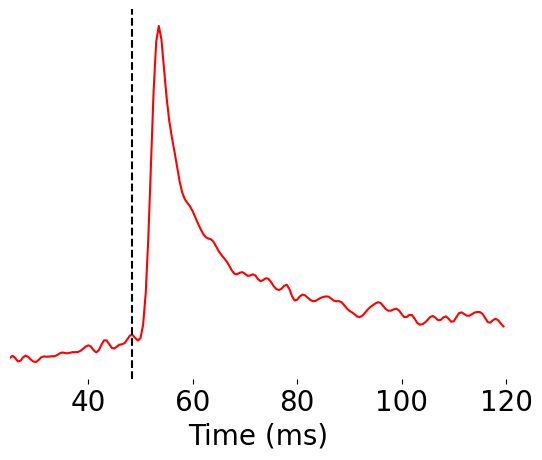

10/23/2024 2 1 2
trace       Pt      ROI1
0      0 -0.002925
1      1 -0.034703
2      2 -0.054380
3      3 -0.058536
4      4 -0.051615
..   ...       ...
894  894 -0.009427
895  895 -0.001075
896  896 -0.001237
897  897 -0.011857
898  898 -0.028303

[899 rows x 2 columns]


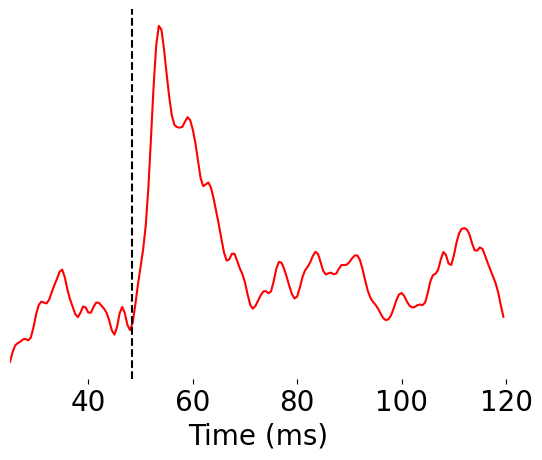

10/23/2024 2 1 3
trace       Pt      ROI1
0      0 -0.009811
1      1 -0.064524
2      2 -0.105530
3      3 -0.128077
4      4 -0.135398
..   ...       ...
894  894 -0.042423
895  895 -0.038161
896  896 -0.040033
897  897 -0.050612
898  898 -0.063425

[899 rows x 2 columns]


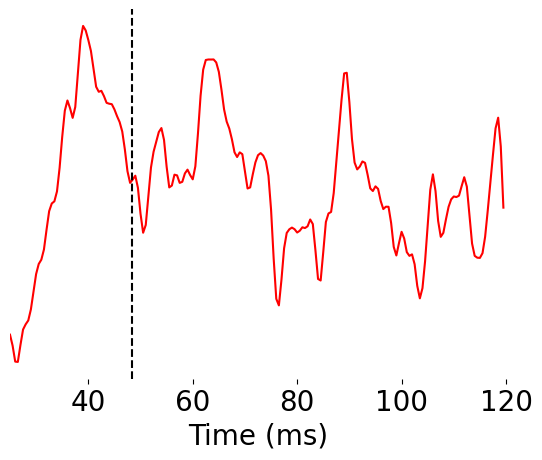

10/23/2024 2 1 4
trace       Pt      ROI1
0      0 -0.089434
1      1 -0.110482
2      2 -0.118550
3      3 -0.112874
4      4 -0.099420
..   ...       ...
894  894 -0.146505
895  895 -0.151651
896  896 -0.148751
897  897 -0.141752
898  898 -0.135303

[899 rows x 2 columns]


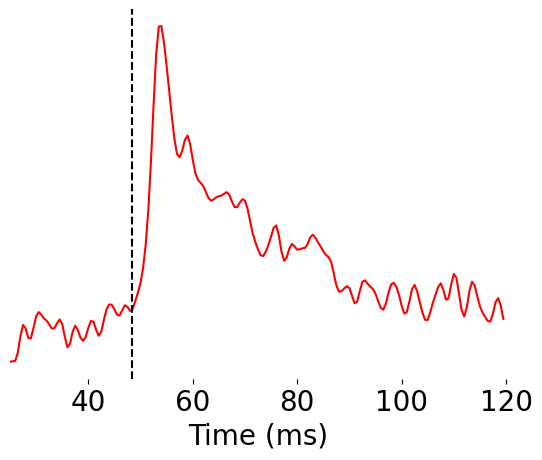

10/23/2024 2 1 5
trace       Pt      ROI1
0      0  0.013258
1      1 -0.028888
2      2 -0.059339
3      3 -0.077005
4      4 -0.088073
..   ...       ...
894  894 -0.055424
895  895 -0.033524
896  896 -0.006673
897  897  0.009811
898  898  0.012261

[899 rows x 2 columns]


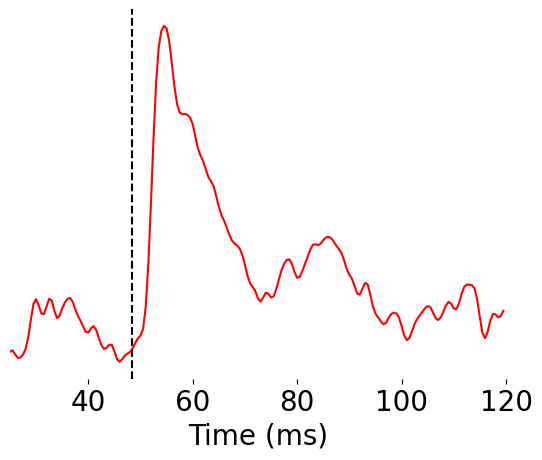

10/23/2024 2 1 6
trace       Pt      ROI1
0      0  0.004171
1      1 -0.041978
2      2 -0.075096
3      3 -0.093005
4      4 -0.098950
..   ...       ...
894  894 -0.105300
895  895 -0.107492
896  896 -0.094144
897  897 -0.079389
898  898 -0.077056

[899 rows x 2 columns]


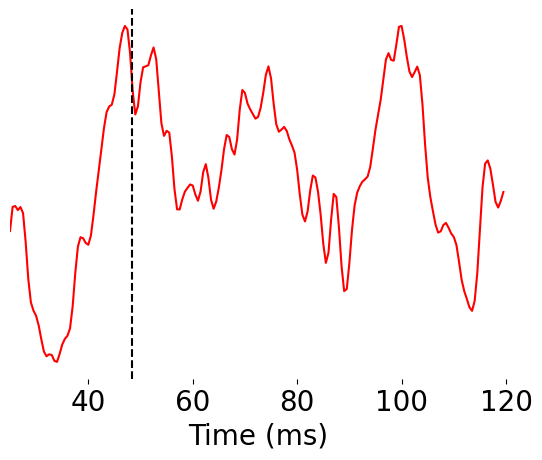

10/23/2024 2 1 7
trace       Pt      ROI1
0      0 -0.006543
1      1 -0.044114
2      2 -0.073585
3      3 -0.091774
4      4 -0.097570
..   ...       ...
894  894 -0.160125
895  895 -0.161771
896  896 -0.174012
897  897 -0.192615
898  898 -0.211547

[899 rows x 2 columns]


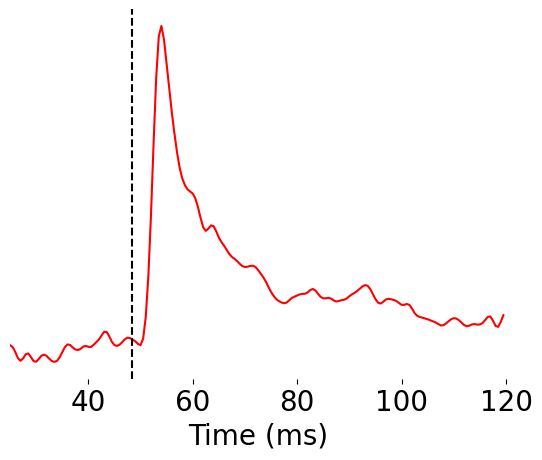

10/23/2024 2 1 8
trace       Pt      ROI1
0      0 -0.021596
1      1 -0.072556
2      2 -0.115341
3      3 -0.143349
4      4 -0.152907
..   ...       ...
894  894 -0.201753
895  895 -0.191690
896  896 -0.210282
897  897 -0.249672
898  898 -0.292632

[899 rows x 2 columns]


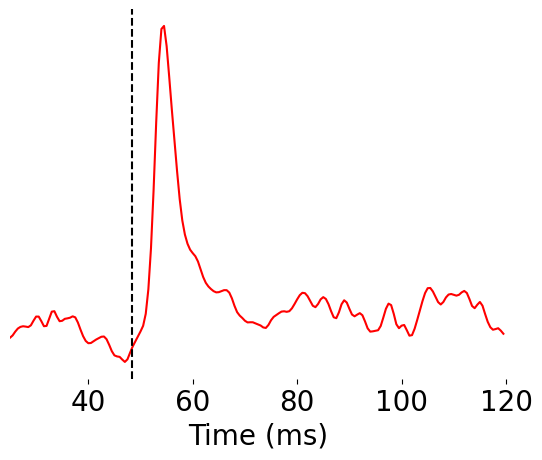

10/23/2024 2 1 9
trace       Pt      ROI1
0      0  0.037721
1      1 -0.005850
2      2 -0.044395
3      3 -0.070829
4      4 -0.081411
..   ...       ...
894  894 -0.158560
895  895 -0.178682
896  896 -0.200037
897  897 -0.225039
898  898 -0.255558

[899 rows x 2 columns]


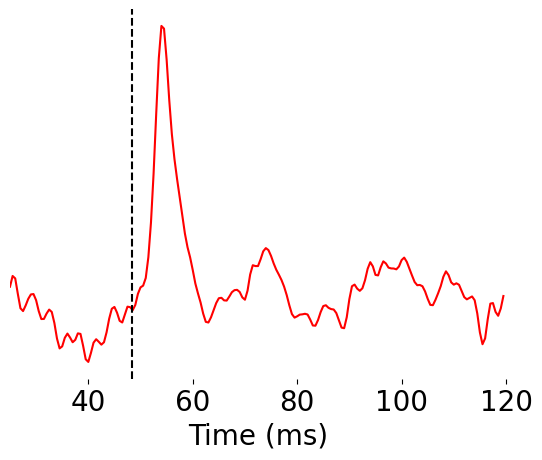

10/23/2024 2 1 10
trace       Pt      ROI1
0      0 -0.165329
1      1 -0.187552
2      2 -0.195165
3      3 -0.193011
4      4 -0.188733
..   ...       ...
894  894  0.059180
895  895  0.045040
896  896  0.028462
897  897  0.022963
898  898  0.029700

[899 rows x 2 columns]


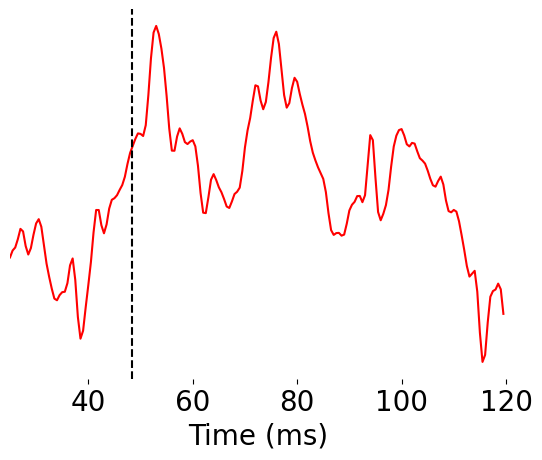

10/23/2024 2 1 11
trace       Pt      ROI1
0      0 -0.193121
1      1 -0.238218
2      2 -0.261624
3      3 -0.259548
4      4 -0.239921
..   ...       ...
894  894 -0.033719
895  895 -0.053475
896  896 -0.069800
897  897 -0.067496
898  898 -0.051143

[899 rows x 2 columns]


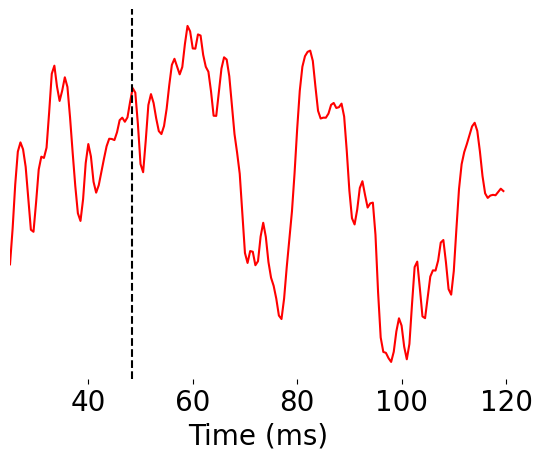

10/23/2024 2 1 12
trace       Pt      ROI1
0      0  0.060489
1      1 -0.006560
2      2 -0.059104
3      3 -0.089407
4      4 -0.097696
..   ...       ...
894  894 -0.123368
895  895 -0.122418
896  896 -0.129075
897  897 -0.153009
898  898 -0.187026

[899 rows x 2 columns]


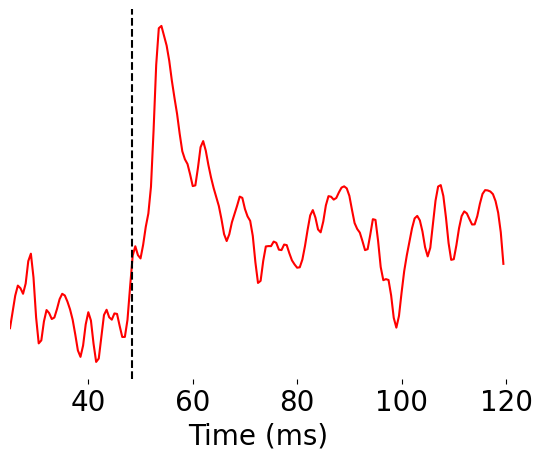

10/23/2024 2 1 13
trace       Pt      ROI1
0      0  0.055735
1      1 -0.034913
2      2 -0.110757
3      3 -0.162828
4      4 -0.191931
..   ...       ...
894  894 -0.090479
895  895 -0.086362
896  896 -0.081816
897  897 -0.087557
898  898 -0.110127

[899 rows x 2 columns]


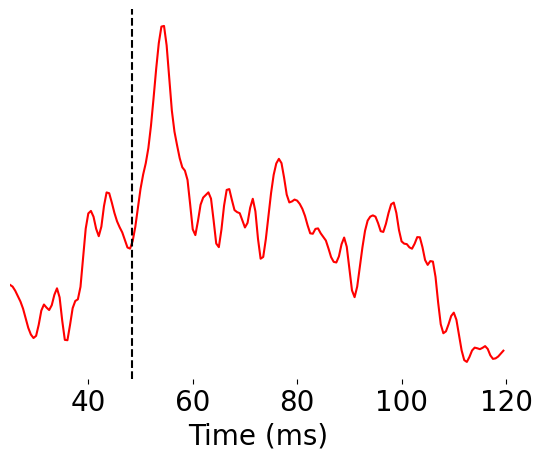

10/23/2024 3 1 1
trace       Pt      ROI1
0      0  0.045914
1      1  0.015420
2      2 -0.007909
3      3 -0.021541
4      4 -0.024985
..   ...       ...
894  894 -0.114474
895  895 -0.097794
896  896 -0.084525
897  897 -0.093911
898  898 -0.126731

[899 rows x 2 columns]


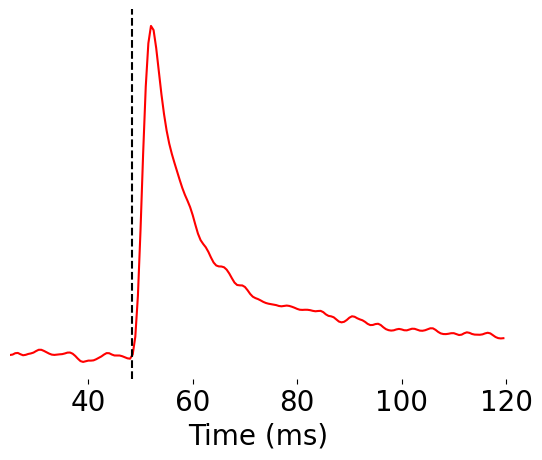

10/23/2024 3 1 2
trace       Pt      ROI1
0      0 -0.036656
1      1 -0.068984
2      2 -0.086438
3      3 -0.085699
4      4 -0.074048
..   ...       ...
894  894 -0.074821
895  895 -0.065675
896  896 -0.050788
897  897 -0.034503
898  898 -0.024126

[899 rows x 2 columns]


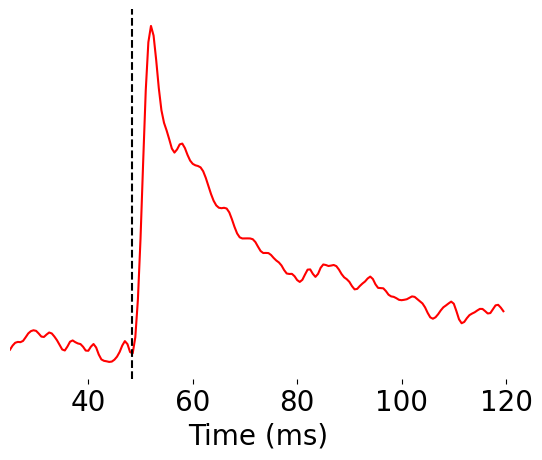

10/23/2024 3 1 3
trace       Pt      ROI1
0      0 -0.080493
1      1 -0.116118
2      2 -0.144274
3      3 -0.160667
4      4 -0.160934
..   ...       ...
894  894 -0.032193
895  895 -0.025372
896  896 -0.036896
897  897 -0.060668
898  898 -0.085017

[899 rows x 2 columns]


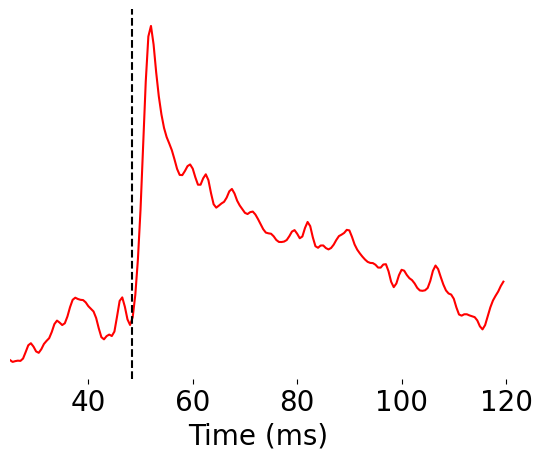

10/23/2024 3 1 4
trace       Pt      ROI1
0      0  0.048063
1      1  0.007852
2      2 -0.027088
3      3 -0.051144
4      4 -0.061256
..   ...       ...
894  894 -0.084464
895  895 -0.088281
896  896 -0.093859
897  897 -0.106068
898  898 -0.124623

[899 rows x 2 columns]


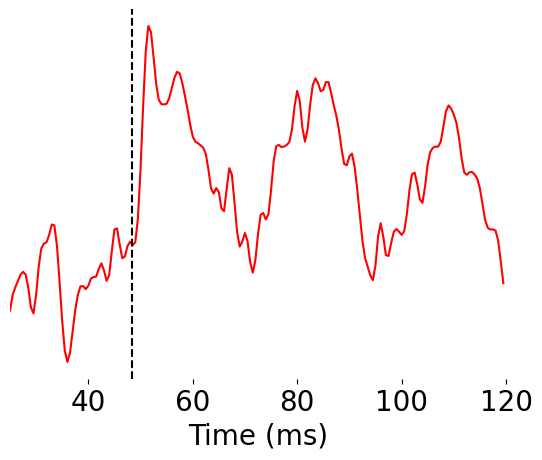

10/23/2024 3 1 5
trace       Pt      ROI1
0      0 -0.012906
1      1 -0.050796
2      2 -0.079801
3      3 -0.096099
4      4 -0.101334
..   ...       ...
894  894 -0.020907
895  895 -0.035969
896  896 -0.054317
897  897 -0.077091
898  898 -0.104136

[899 rows x 2 columns]


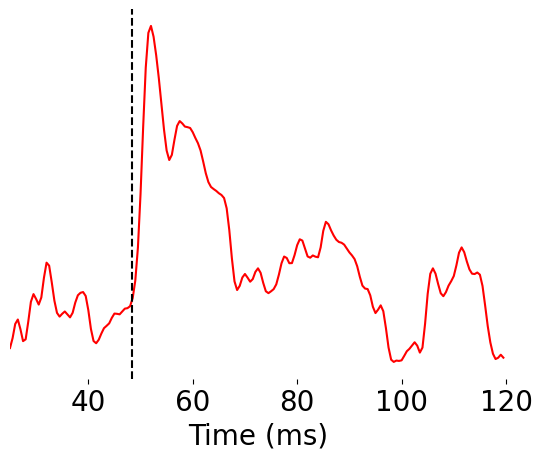

10/23/2024 3 1 6
trace       Pt      ROI1
0      0  0.030629
1      1 -0.018190
2      2 -0.046876
3      3 -0.059213
4      4 -0.075748
..   ...       ...
894  894 -0.122401
895  895 -0.131140
896  896 -0.127421
897  897 -0.122098
898  898 -0.119631

[899 rows x 2 columns]


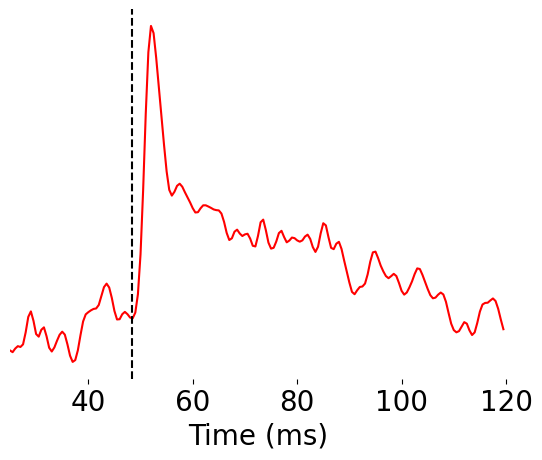

10/29/2024 2 1 1
trace       Pt      ROI1
0      0 -0.255084
1      1 -0.221591
2      2 -0.164055
3      3 -0.069963
4      4  0.019674
..   ...       ...
894  894 -0.493852
895  895 -0.546011
896  896 -0.532492
897  897 -0.503049
898  898 -0.527941

[899 rows x 2 columns]


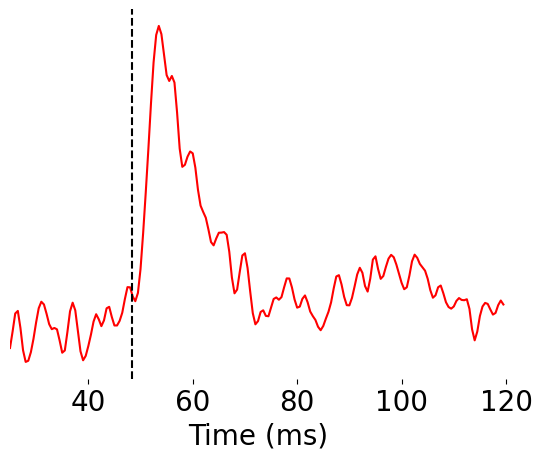

10/29/2024 2 1 2
trace       Pt      ROI1
0      0 -0.532296
1      1 -0.426542
2      2 -0.277714
3      3 -0.053187
4      4  0.214958
..   ...       ...
894  894 -0.143430
895  895 -0.199298
896  896 -0.351549
897  897 -0.585136
898  898 -0.825490

[899 rows x 2 columns]


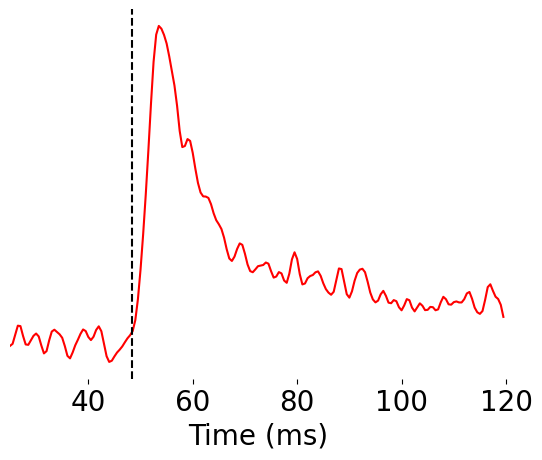

10/29/2024 2 1 3
trace       Pt      ROI1
0      0  0.705548
1      1  0.302680
2      2 -0.046171
3      3 -0.279845
4      4 -0.411643
..   ...       ...
894  894 -0.273831
895  895 -0.167847
896  896 -0.015779
897  897  0.094070
898  898  0.100549

[899 rows x 2 columns]


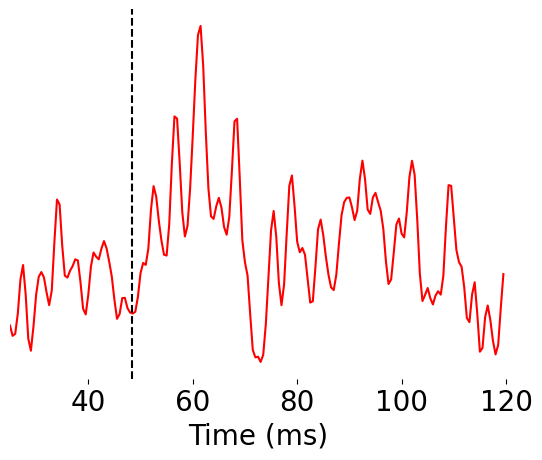

10/29/2024 2 1 4
trace       Pt      ROI1
0      0 -0.133932
1      1 -0.350472
2      2 -0.473112
3      3 -0.470975
4      4 -0.386038
..   ...       ...
894  894 -0.302974
895  895 -0.168319
896  896 -0.091221
897  897 -0.097951
898  898 -0.137474

[899 rows x 2 columns]


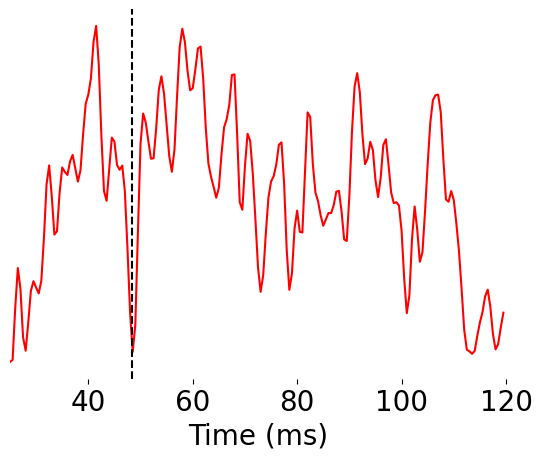

10/29/2024 2 1 5
trace       Pt      ROI1
0      0 -0.223085
1      1 -0.141198
2      2 -0.084388
3      3 -0.101690
4      4 -0.209503
..   ...       ...
894  894 -0.366907
895  895 -0.503812
896  896 -0.590434
897  897 -0.592197
898  898 -0.535780

[899 rows x 2 columns]


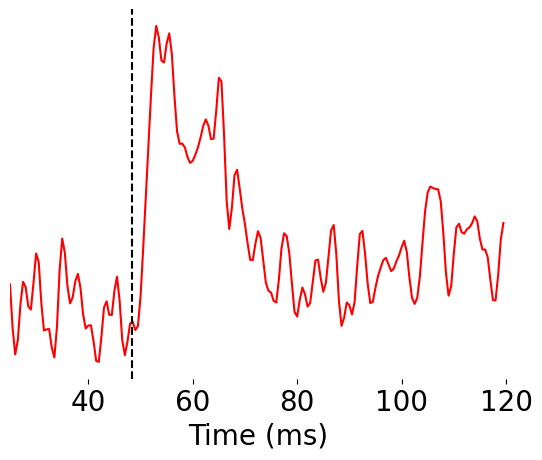

10/29/2024 3 1 1
trace       Pt      ROI1
0      0  0.075365
1      1  0.024139
2      2 -0.017933
3      3 -0.041328
4      4 -0.041635
..   ...       ...
894  894 -0.112220
895  895 -0.108492
896  896 -0.101068
897  897 -0.096881
898  898 -0.098915

[899 rows x 2 columns]


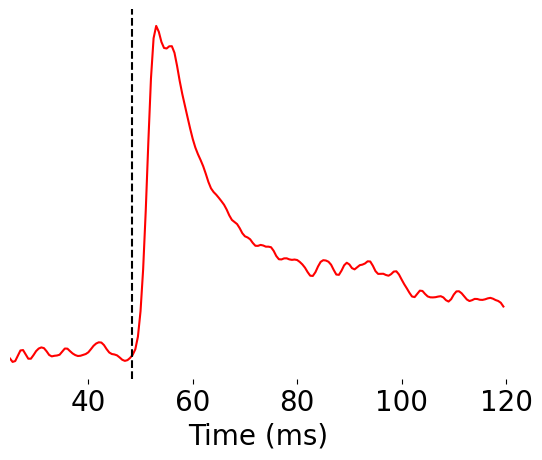

10/29/2024 3 1 2
trace       Pt      ROI1
0      0 -0.069337
1      1 -0.102915
2      2 -0.127965
3      3 -0.138477
4      4 -0.129814
..   ...       ...
894  894 -0.061825
895  895 -0.066136
896  896 -0.068479
897  897 -0.075368
898  898 -0.090173

[899 rows x 2 columns]


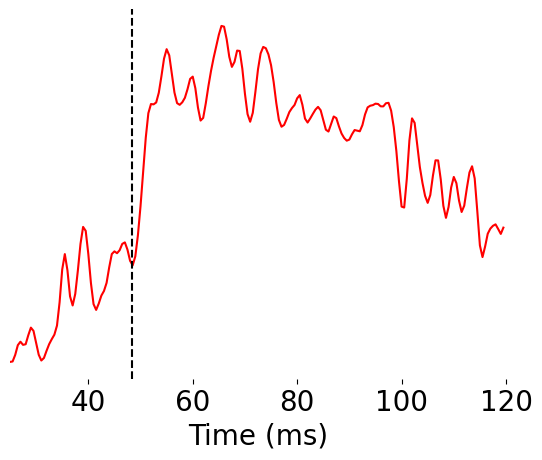

10/29/2024 3 1 3
trace       Pt      ROI1
0      0 -0.088115
1      1 -0.108985
2      2 -0.120809
3      3 -0.126951
4      4 -0.132409
..   ...       ...
894  894 -0.104506
895  895 -0.098085
896  896 -0.091218
897  897 -0.097613
898  898 -0.118100

[899 rows x 2 columns]


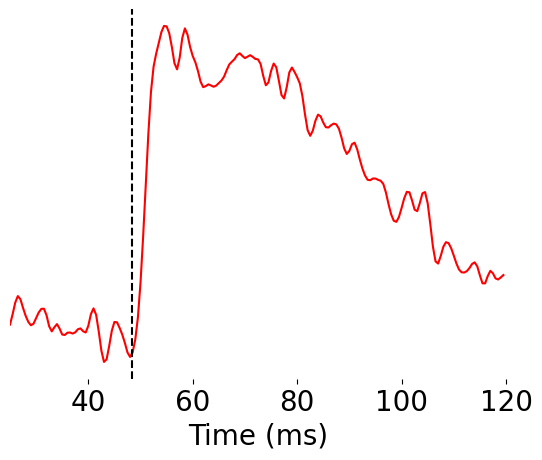

10/29/2024 3 1 4
trace       Pt      ROI1
0      0 -0.119574
1      1 -0.138110
2      2 -0.140562
3      3 -0.133142
4      4 -0.129516
..   ...       ...
894  894 -0.059008
895  895 -0.047680
896  896 -0.020326
897  897  0.000061
898  898 -0.000369

[899 rows x 2 columns]


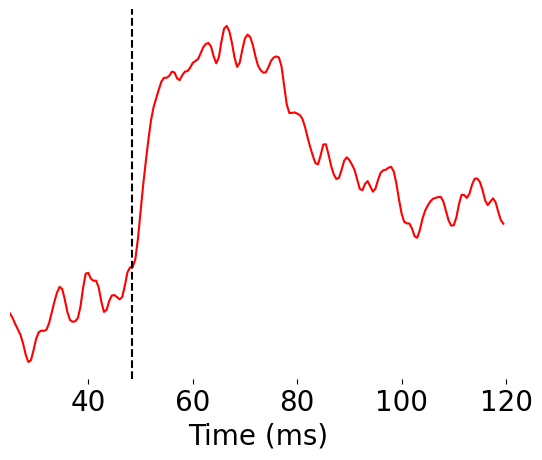

10/29/2024 3 1 5
trace       Pt      ROI1
0      0  0.059589
1      1  0.008049
2      2 -0.022843
3      3 -0.032979
4      4 -0.032537
..   ...       ...
894  894 -0.178338
895  895 -0.178353
896  896 -0.175404
897  897 -0.177177
898  898 -0.189097

[899 rows x 2 columns]


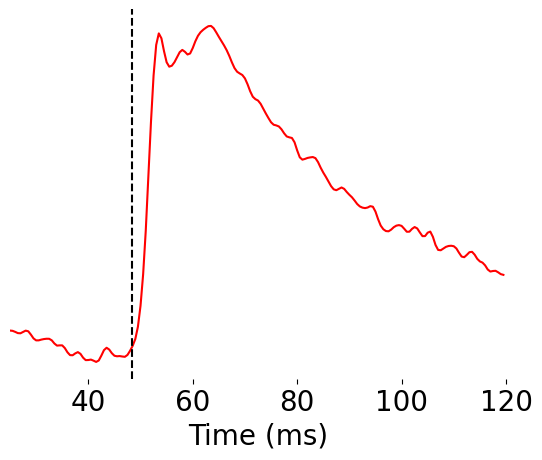

10/29/2024 3 1 6
trace       Pt      ROI1
0      0 -0.004928
1      1 -0.067854
2      2 -0.117467
3      3 -0.141201
4      4 -0.135499
..   ...       ...
894  894 -0.143167
895  895 -0.126767
896  896 -0.112979
897  897 -0.121126
898  898 -0.146050

[899 rows x 2 columns]


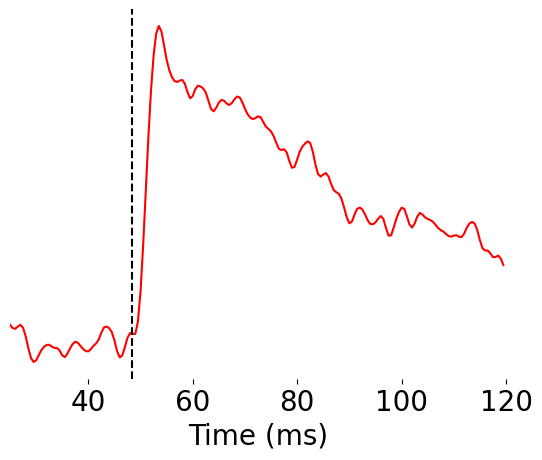

10/29/2024 3 1 7
trace       Pt      ROI1
0      0 -0.141489
1      1 -0.204872
2      2 -0.257418
3      3 -0.285787
4      4 -0.279882
..   ...       ...
894  894 -0.074845
895  895 -0.093206
896  896 -0.105977
897  897 -0.130270
898  898 -0.168412

[899 rows x 2 columns]


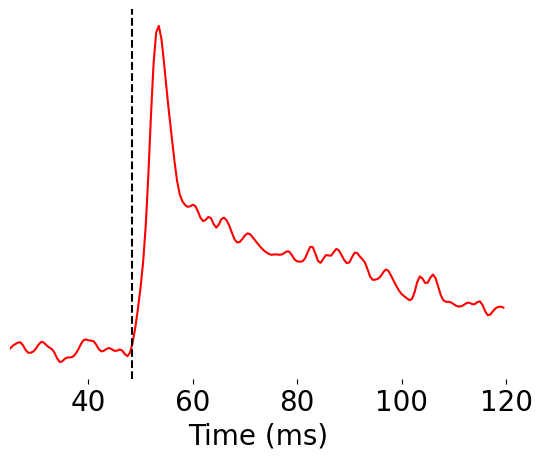

10/29/2024 3 1 8
trace       Pt      ROI1
0      0 -0.094717
1      1 -0.166056
2      2 -0.217405
3      3 -0.234370
4      4 -0.212939
..   ...       ...
894  894  0.010558
895  895 -0.016213
896  896 -0.047846
897  897 -0.052338
898  898 -0.029733

[899 rows x 2 columns]


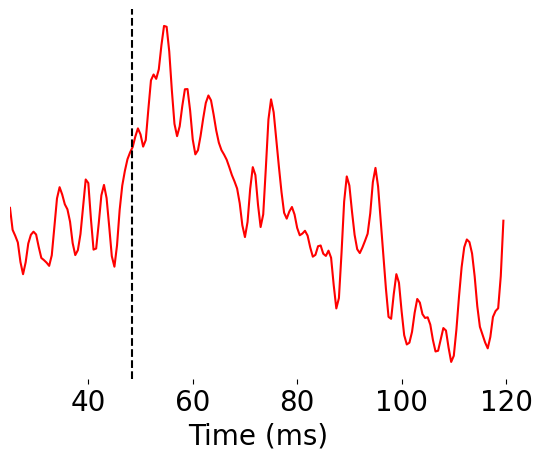

10/29/2024 3 1 9
trace       Pt      ROI1
0      0 -0.069068
1      1 -0.144669
2      2 -0.206194
3      3 -0.244374
4      4 -0.261145
..   ...       ...
894  894 -0.026244
895  895 -0.010769
896  896 -0.021501
897  897 -0.042101
898  898 -0.061903

[899 rows x 2 columns]


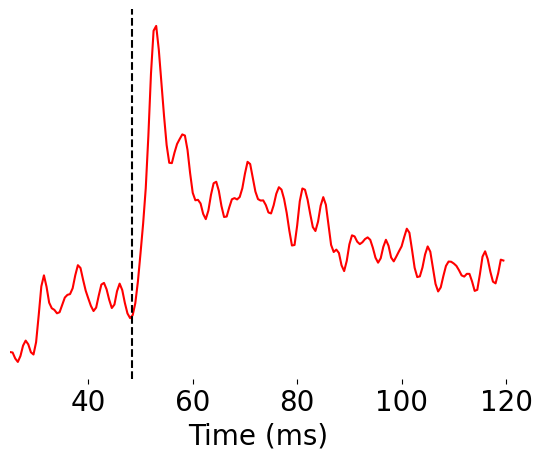

10/29/2024 3 1 10
trace       Pt      ROI1
0      0 -0.065918
1      1 -0.120781
2      2 -0.150106
3      3 -0.153063
4      4 -0.145245
..   ...       ...
894  894 -0.039977
895  895 -0.046496
896  896 -0.080300
897  897 -0.119729
898  898 -0.153790

[899 rows x 2 columns]


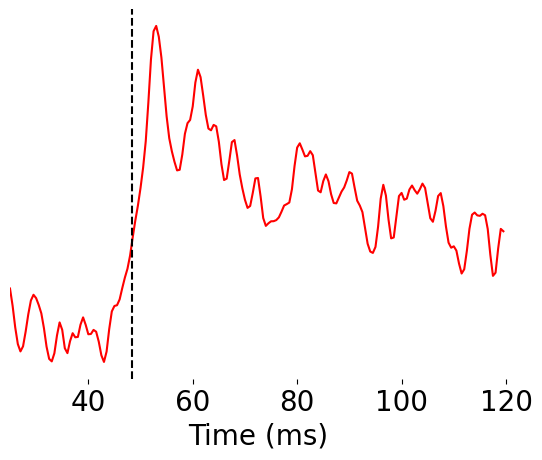

10/29/2024 3 1 11
trace       Pt      ROI1
0      0 -0.172369
1      1 -0.236333
2      2 -0.263539
3      3 -0.262030
4      4 -0.256268
..   ...       ...
894  894  0.034121
895  895  0.009162
896  896 -0.020228
897  897 -0.040111
898  898 -0.056523

[899 rows x 2 columns]


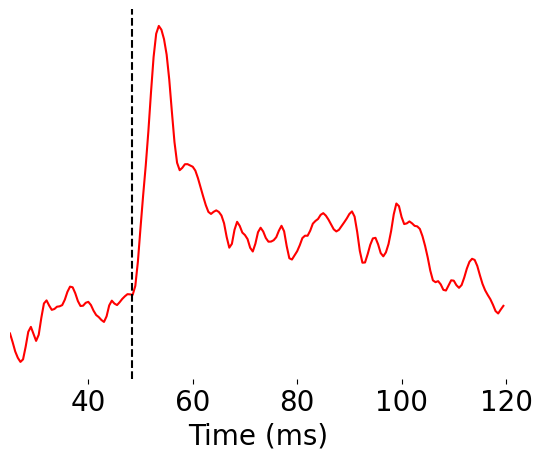

7/19/2024 2 1 1
trace       Pt      ROI1
0      0 -0.068382
1      1 -0.047971
2      2 -0.045332
3      3 -0.067760
4      4 -0.104372
..   ...       ...
894  894 -0.003298
895  895  0.033662
896  896  0.085322
897  897  0.115703
898  898  0.111669

[899 rows x 2 columns]


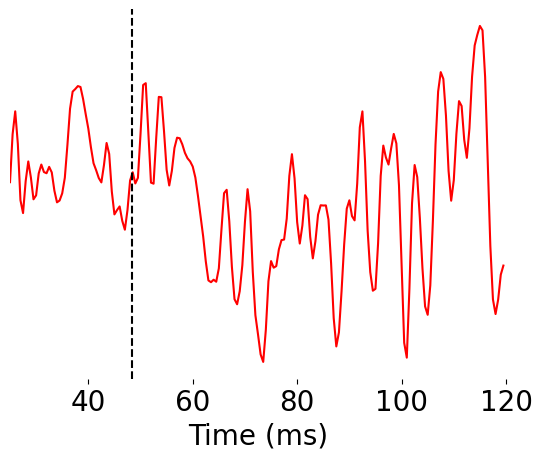

7/19/2024 2 1 2
trace       Pt      ROI1
0      0 -0.135190
1      1 -0.149784
2      2 -0.150096
3      3 -0.133101
4      4 -0.096184
..   ...       ...
894  894  0.006985
895  895 -0.022881
896  896 -0.054126
897  897 -0.071636
898  898 -0.075590

[899 rows x 2 columns]


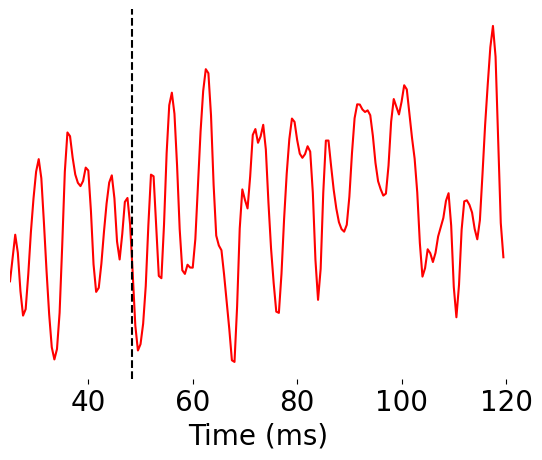

7/19/2024 2 1 3
trace       Pt      ROI1
0      0 -0.255310
1      1 -0.294668
2      2 -0.313840
3      3 -0.305549
4      4 -0.282172
..   ...       ...
894  894  0.046653
895  895  0.037070
896  896 -0.003606
897  897 -0.051214
898  898 -0.088792

[899 rows x 2 columns]


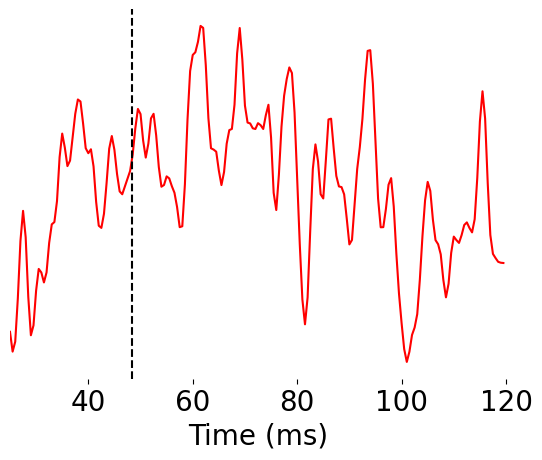

7/19/2024 2 1 4
trace       Pt      ROI1
0      0  0.035977
1      1 -0.013939
2      2 -0.054007
3      3 -0.087882
4      4 -0.116483
..   ...       ...
894  894  0.024658
895  895  0.047021
896  896  0.039630
897  897  0.000372
898  898 -0.053308

[899 rows x 2 columns]


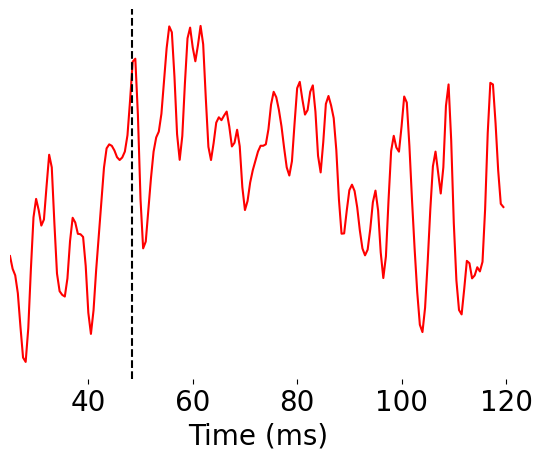

7/19/2024 2 1 5
trace       Pt      ROI1
0      0 -0.096947
1      1 -0.155244
2      2 -0.179637
3      3 -0.165766
4      4 -0.142118
..   ...       ...
894  894 -0.158679
895  895 -0.136544
896  896 -0.103847
897  897 -0.088596
898  898 -0.101511

[899 rows x 2 columns]


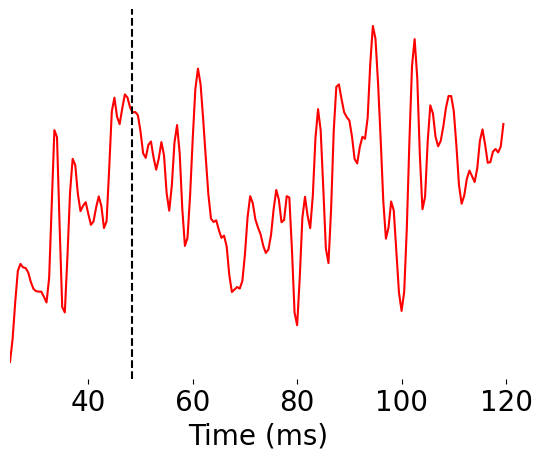

7/19/2024 2 1 6
trace       Pt      ROI1
0      0 -0.157899
1      1 -0.166017
2      2 -0.161367
3      3 -0.146690
4      4 -0.141041
..   ...       ...
894  894 -0.065254
895  895 -0.066092
896  896 -0.087680
897  897 -0.124192
898  898 -0.152192

[899 rows x 2 columns]


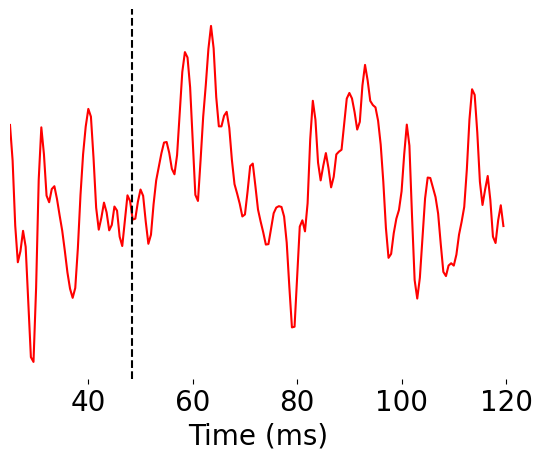

7/19/2024 2 1 7
trace       Pt      ROI1
0      0  0.063676
1      1 -0.033095
2      2 -0.100421
3      3 -0.134818
4      4 -0.152900
..   ...       ...
894  894  0.022482
895  895  0.102050
896  896  0.149700
897  897  0.152943
898  898  0.117593

[899 rows x 2 columns]


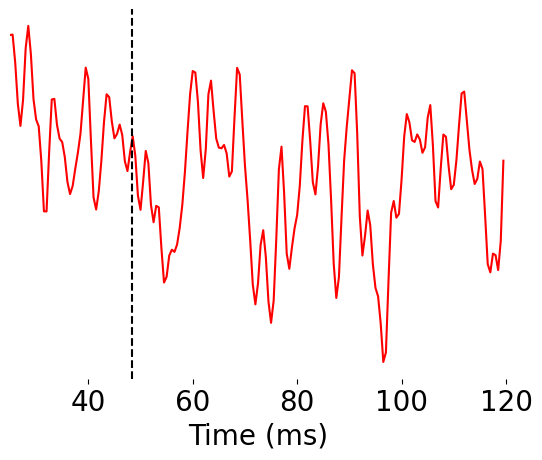

In [ ]:
# plot the traces from 10/23/24 slice 2
for date in df_export['Date'].unique():
    date_df = df_export[df_export['Date'] == date]
    for slic in date_df['Slice'].unique():
        slic_df = date_df[date_df['Slice'] == slic]
        for loc in slic_df['Location'].unique():
            loc_df = slic_df[slic_df['Location'] == loc]
            for rec in loc_df['Recording'].unique():
                rec_df = loc_df[loc_df['Recording'] == rec]
                
                print(date, slic, loc, rec)
                trace_file = rec_df['trace'].values[0]

                # read in the trace file
                trace = read_traces_file(trace_file)
                print("trace", trace)
                tm = TraceMetrics(trace)
                tm.show_traces(measure_window=[50, 240], 
                                legend=False, 
                                colors=['r', 'cyan', 'm', 'orange', 'green', 'purple',
                                        'r', 'green', 'cyan', 'm', 'yellow', 'g', 'y', 'm', 'c', 'k'],
                                stim_time=48.3,
                                #ylim=[-6.5, 1.5],
                                        )
                    

## 